# Práctica Temas 4 y 5

**Alumno:** Iván Cañaveral Sánchez

El objetivo principal de esta práctica el uso de modelos contextuales ya pre-entrenados o incluso ya ajustados a la tarea, para continuar trabajando con el dataset utilizado en las anteriores prácticas, basado en reseñas de películas clasificadas como positivas y negativas.

El documento se estructura en 3 apartados principales:
1. Estudio del impacto del preprocesado del texto
2. Entrenamiento de modelos base
3. Evaluación y entrenamiento de modelos afinados para tareas similares

## Preparación

### Instalación de dependencias

A continuación instalamos las dependencias adicionales necesarias para la ejecución de la práctica.

In [1]:
%%capture
!pip install transformers evaluate

### Librerías y constantes

En este apartado importaremos todas las librerías, clases y módulos necesarios para el desarrollo de la práctica. 

Adicionalmente, definiremos algunas constantes de especial relevancia a modo de variables globales, como el tamaño del batch o el número de épochs. Hacemos esto para que sean reutilizables en todas las pruebas y establecer un marco comparativo con configuraciones similares de los entrenamientos.

In [2]:
import os
import re
import json
import time
import shutil
import string
import itertools

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
#import warnings
#warnings.filterwarnings("ignore")
#warnings.simplefilter('ignore')
#tf.keras.utils.disable_interactive_logging()
#tf.autograph.set_verbosity(0)
#tf.get_logger().setLevel(logging.ERROR)

In [6]:
import transformers
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback

In [7]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [8]:
import evaluate
from datasets import Dataset

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [11]:
import nltk
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [12]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
sns.set_theme()
sns.set(rc={'figure.figsize':(4, 4)})

In [14]:
N_EPOCHS = 5
BATCH_SIZE = 8

In [15]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [16]:
accuracy = evaluate.load("accuracy")

In [17]:
from transformers import TFAutoModelForSequenceClassification, TFDistilBertForSequenceClassification, TFAutoModel, AutoModelForSequenceClassification, AutoConfig

In [18]:
import gc
import ctypes

In [19]:
#os.makedirs('checkpoints', exist_ok=True)
#checkpoint_callback = ModelCheckpoint(os.path.join('checkpoints/', model_name))

Dado el tamaño de los modelos con los que vamos a trabajar y las dificultades de gestión de la memoria de la GPU desde un notebook, vamos a crear esta función para liberar la memoria de la misma entre experimento y experimento.

In [20]:
def clear_memory():
    tf.keras.backend.clear_session()
    try:
        del model
    except NameError:
        pass
    gc.collect()
    libc = ctypes.CDLL("libc.so.6") # clearing cache 
    libc.malloc_trim(0)

# 0. Obtención del dataset

Para mejorar la usabilidad y reducir la complejidad de la obtención de los datos, hemos subido el dataset a un repositorio abierto de github, desde donde se pueden clonar sin problema.

En general no es una práctica recomendada mantener los datasets directamente en github (para ello existen aproximaciones más eficientes como DVC), pero dado el tamaño y la naturaleza del dataset, entendemos que no supone gran problema y facilita la ejecución del notebook.

In [21]:
!git clone https://github.com/ivanCanaveral/msc-datasets/

Cloning into 'msc-datasets'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), 5.21 MiB | 1.73 MiB/s, done.


## 0.1. Carga de datos

Vamos a proceder a la carga de ambos datasets (train y test). Para hacer más sencillos algunos análisis, lo unificaremos en un único dataset, que dispondrá de la variable `partition: test|train` para poder filtrarlos fácilmente después.

In [22]:
raw_test_data = pd.read_csv('msc-datasets/movie-reviews/test_reviews.csv')
raw_train_data = pd.read_csv('msc-datasets/movie-reviews/train_reviews.csv')

In [23]:
raw_test_data['partition'] = 'test'
raw_train_data['partition'] = 'train'
dataset = pd.concat([raw_test_data, raw_train_data])

In [24]:
dataset['review'] = dataset.review.str.split().apply(lambda x: ' '.join(x[:250]))
dataset = dataset.sample(frac=0.8, random_state=73)

In [25]:
dataset = dataset.set_index(dataset.id).drop(columns=["id"])
dataset["length"] = dataset.review.str.split().apply(len)
dataset.head()

,review,sentiment,partition,length
id,,,,
6505,I tried watching this abomination of the cinem...,negative,test,250
9650,How anyone can say this is bad is beyond me. I...,positive,train,119
13635,The Bill was essentially a cultural fountain f...,positive,test,250
1615,"Bravo! Morgan Freeman is an actor, who researc...",positive,train,250
13648,Today's sci-fi thrillers are more like Rambo i...,positive,test,138


Procedemos a realizar un conteo de los textos de las distintas clases sobre el dataset original:

In [26]:
dataset.groupby(by=["partition", "sentiment"]).count()

review  length
partition sentiment                
test      negative      823     823
          positive      778     778
train     negative     3199    3199
          positive     3200    3200

## 0.2. Procesado de los textos

A continuación vamos a explorar el texto y vamos a intentar aplicar mejoras en la limpieza del mismo según vayamos analizando los resultados.

Para mejorar la lectura del código y el encapsulamiento del mismo, vamos a creamos una clase que hereda de las clases de estimadores de Sklearn.

⚠️`WordNetLemmatizer()` no es un objeto serializable por joblib (una de las librerías que utiliza sklearn para paralelizar cálculos), por lo que ajustaremos la opción njobs=1, para evitar potenciales problemas.

Para, una vez más, aportar sencillez, vamos a establecer 3 tipos de preprocesado, que serán incrementales:

* `basic`: únicamente se hace una limpieza básica, pasando a minúsculas, filtrando caracteres indeseados y stopwords.
* `lemma`: sobre el tratamiento basic se aplica lemmatización.
* `stem`: adicionalmente al lemmatizado, se aplica stemming.

In [27]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, level='basic'):
        assert level in ['basic', 'lemma', 'stem'], "Wrong level value"
        self.level = level
        self.apply_lemma = level != 'basic'
        self.apply_stem = level == 'stem'
    
    def clean_text(self, text):
        letters_only = re.sub("[^a-zA-Z]", " ", text)
        words = letters_only.lower().split()
        stops = set(stopwords.words("english") + ['br'])
        words = [w for w in words if not w in stops]
        return words

    def lemmatize_words(self, words):
        wordnet_lemmatizer = WordNetLemmatizer()
        lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in words]
        return lemmatized
    
    def stem_words(self, words):
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(word) for word in words]
        return stemmed

    def parse_text(self, text):
        words = self.clean_text(text)
        if self.apply_lemma:
            words = self.lemmatize_words(words)
        if self.apply_stem:
            words = self.stem_words(words)
        return " ".join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.vectorize(self.parse_text)(X)

    def get_params(self, deep=True):
        return {
            "level": self.level
        }

Dado que el dataset no es demasiado grande, vamos a procesar el corpus y a guardarlo en nuevas columnas del dataframe de pandas.

In [28]:
for prep_type in ['basic', 'lemma', 'stem']:
  print("Procesando...", prep_type, end=' ')
  t0 = time.time()
  text_preprocessor = TextPreprocessor(prep_type)
  dataset[f'{prep_type}_review'] = text_preprocessor.transform(dataset.review)
  print(f"{time.time()-t0:02f} s.")

Procesando... basic 5.107482 s.
Procesando... lemma 6.757981 s.
Procesando... stem 20.047323 s.


In [29]:
dataset['label'] = dataset['sentiment'] == 'positive'
dataset['label'] = dataset['label'].astype('int32')
dataset.head(2)

,review,sentiment,partition,length,basic_review,lemma_review,stem_review,label
id,,,,,,,,
6505,I tried watching this abomination of the cinem...,negative,test,250,tried watching abomination cinema five years o...,tried watching abomination cinema five year ol...,tri watch abomin cinema five year old never si...,0
9650,How anyone can say this is bad is beyond me. I...,positive,train,119,anyone say bad beyond loved show even saw reas...,anyone say bad beyond loved show even saw reas...,anyon say bad beyond love show even saw reason...,1


In [30]:
#dataset = dataset.sample(frac=0.1)

In [31]:
train_df = dataset[dataset['partition'] == 'train']
test_df = dataset[dataset['partition'] == 'test']

# 1. Preprocessing tests

En este apartado vamos a evaluar el rendimiento de los entrenamientos sobre los distintos niveles de preprocesado de los textos:

- Texto bruto
- Con limpieza básica
- Lemmatización
- Stemming

El objetivo es entender, dado un modelo contextual, cómo afecta el tratamiento del texto en su rendimiento.

Para la comparativa utilizaremos un mismo modelo base, lo reentrenaremos y evaluaremos su rendimiento para todos los casos. Hemos elegido `distilbert` por su compromiso entre tamaño y eficacia.

## 1.1. Raw

En primer lugar vamos a ejecutar las pruebas utilizando directamente el texto en bruto.

Dividiremos el dataset de entrenamiento en `entrenamiento` y `validación`, y evaluaremos los resultados contra el conjunto original de `test`.

(!) En este primer entrenamiento vamos a detenernos un poco más en los detalles del proceso, y en los siguientes entrenamientos simplemente reproduciremos el código.

### Dataset

Vamos a generar los datsets mencionados, y posteriormente vamos a tokenizarlos utilizando el tokenizador específico de este modelo.

In [ ]:
model_name = 'distilbert-base-uncased'
#model_name = 'distilroberta-base'

In [ ]:
dataset['text'] = dataset['review']
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

In [ ]:
tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

Vamos a visualizar cómo es el resultado de la tokenización. 

El output resultante para cada texto tiene dos entradas:

- input_ids: el id generado para el token en concreto.
- attention_mask: output que nos indica si el token correspondiente se va a utilizar o no.

In [ ]:
print(train_encodings["input_ids"][5][:25])
print(train_encodings["attention_mask"][5][:25])

[101, 2023, 6925, 2241, 2006, 2048, 9586, 5297, 18922, 4109, 1006, 1000, 1996, 2991, 1997, 1996, 2160, 1997, 20774, 1000, 1010, 1000, 3153, 1997, 2331]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Si aplicamos el método `decode` del tokenizador, podemos ver el resultado inverso de la tokenización, y ver los detalles. En primer lugar vamos a decodificar token a token, y a continuación una frase completa:

In [ ]:
for token_id in train_encodings["input_ids"][5][:25]:
    print("id:",token_id,"\ttoken:",tokenizador.decode(token_id))

id: 101 	token: [CLS]
id: 2023 	token: this
id: 6925 	token: tale
id: 2241 	token: based
id: 2006 	token: on
id: 2048 	token: two
id: 9586 	token: edgar
id: 5297 	token: allen
id: 18922 	token: poe
id: 4109 	token: pieces
id: 1006 	token: (
id: 1000 	token: "
id: 1996 	token: the
id: 2991 	token: fall
id: 1997 	token: of
id: 1996 	token: the
id: 2160 	token: house
id: 1997 	token: of
id: 20774 	token: usher
id: 1000 	token: "
id: 1010 	token: ,
id: 1000 	token: "
id: 3153 	token: dance
id: 1997 	token: of
id: 2331 	token: death


In [ ]:
tokenizador.decode(train_encodings["input_ids"][0][:20])

'[CLS] how anyone can say this is bad is beyond me. i loved this show before i even saw'

Vamos a generar Datasets nativos de tensorflow para utilizarlos en el entrenamiento. Los generaremos directamente desde los encodins

In [ ]:
#a partir de los encodings de entrada creamos un dataset que pueda interpretar el modelo. 
#Concretamente, convertimos a tensores la entrada. También añadimos las etiquetas (en nuestro caso en la columna labelNumero)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

In [ ]:
#os.makedirs('checkpoints', exist_ok=True)

In [1]:
# Callback para guardar checkpoints por cada epoch
#checkpoint_callback = ModelCheckpoint(os.path.join('checkpoints/', model_name))

### Training

Vamos a construir un modelo de clasificación a partir de nuestro modelo basado en el encoder BERT utilizando `TFAutoModelForSequenceClassification`, que añadirá una capa densa sobre la codificación para asegurar la clasificación.

Dado que estamos reentrenando un modelo, el learning rate se fija a un nivel relativamente bajo: `5e-5`.

In [ ]:
#from_pt=True cuando el modelo solo está para pytorch. Si no, obtenemos error
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/5
400/400 [==============================] - 403s 936ms/step - loss: 0.3479 - accuracy: 0.8453 - val_loss: 0.2597 - val_accuracy: 0.8894
Epoch 2/5
400/400 [==============================] - 377s 942ms/step - loss: 0.1682 - accuracy: 0.9397 - val_loss: 0.2694 - val_accuracy: 0.8875
Epoch 3/5
400/400 [==============================] - 376s 941ms/step - loss: 0.0851 - accuracy: 0.9712 - val_loss: 0.3790 - val_accuracy: 0.8875
Epoch 4/5
400/400 [==============================] - 377s 942ms/step - loss: 0.0476 - accuracy: 0.9855 - val_loss: 0.3898 - val_accuracy: 0.8869
Epoch 5/5
400/400 [==============================] - 376s 941ms/step - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.4134 - val_accuracy: 0.8856


Como podemos observar, los resultados en clasificación son ya buenos desde el final del primer epoch. A partir de ese momento, las métricas sobre la partición de entrenamiento mejoran, pero sobre la validación se mantienen, o empeoran (`val_loss`), lo que nos indica que el modelo comienza a sufrir de sobre ajuste de manera temprana.

En modelos tan grandes no es descabellado que esto ocurra. Vamos a obtener las métricas ahora contra el conjunto de Test.

### Evaluation

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

125/125 [==============================] - 36s 274ms/step - loss: 0.3557 - accuracy: 0.8925


{'loss': 0.3556949496269226, 'accuracy': 0.8924999833106995}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
test_df[colname] = labels

125/125 [==============================] - 35s 271ms/step


<ipython-input-44-22754443a8f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{model_name}.parquet')

In [ ]:
labels = test_df['label']
predictions = test_df[colname]

In [ ]:
confusion_matrix(labels, predictions)

array([[938,  87],
       [128, 847]])

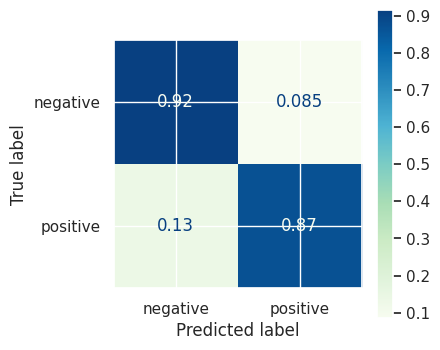

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    labels,
    predictions,
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1025
           1       0.91      0.87      0.89       975

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



Como podemos observar, las métricas de esta primera prueba en general son bastante buenas, tendiendo a marcar como negativos algunos contenidos positivos. 

La `accuracy` global a la que llegamos es de 0.89, con todas sus métricas principales por encima de 0.87

### Guardar y cargar

En este apartado vamos a guardar el modelo entrenado, dado que el entrenamiento es relativamente costoso.

Para comprobar que todo funcionó correctamente, vamos a cargarlo y a volver a obtener alguna de sus métricas.

In [ ]:
os.makedirs('models', exist_ok=True)
model.save_pretrained(os.path.join('models', model_name), saved_model=True)

Volvemos a cargar el modelo:

In [ ]:
config = AutoConfig.from_pretrained(os.path.join('models', model_name, 'config.json'))
model = TFAutoModelForSequenceClassification.from_pretrained(os.path.join('models', model_name), local_files_only=True, config=config)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

Some layers from the model checkpoint at models/distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at models/distilbert-base-uncased and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Y obtenemos la `accuracy`.

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

125/125 [==============================] - 38s 274ms/step - loss: 0.3557 - accuracy: 0.8925


{'loss': 0.3556949496269226, 'accuracy': 0.8924999833106995}

Como podemos ver, el modelo se cargó correctamente, para finalizar vamos a limpiar la memoria y a continuar con el siguiente entrenamiento.

In [ ]:
clear_memory()

## 1.2. Basic

En esta segunda prueba, vamos a entrenar el modelo aplicando una limpieza básica de los textos.

In [ ]:
model_name = 'distilbert-base-uncased'
processing = 'basic_review'

### Dataset 

In [ ]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training 

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/5
400/400 [==============================] - 208s 459ms/step - loss: 0.4363 - accuracy: 0.7869 - val_loss: 0.4917 - val_accuracy: 0.8269
Epoch 2/5
400/400 [==============================] - 182s 455ms/step - loss: 0.2349 - accuracy: 0.9061 - val_loss: 0.3220 - val_accuracy: 0.8694
Epoch 3/5
400/400 [==============================] - 181s 453ms/step - loss: 0.1014 - accuracy: 0.9652 - val_loss: 0.4317 - val_accuracy: 0.8687
Epoch 4/5
400/400 [==============================] - 181s 453ms/step - loss: 0.0443 - accuracy: 0.9869 - val_loss: 0.5511 - val_accuracy: 0.8763
Epoch 5/5
400/400 [==============================] - 182s 454ms/step - loss: 0.0349 - accuracy: 0.9886 - val_loss: 0.4613 - val_accuracy: 0.8687


In [ ]:
os.makedirs('models', exist_ok=True)
model.save_pretrained(f'models/{model_name}_{processing}', saved_model=True)

### Evaluation 

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

125/125 [==============================] - 19s 142ms/step - loss: 0.4990 - accuracy: 0.8545


{'loss': 0.49899163842201233, 'accuracy': 0.8544999957084656}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{model_name}_{processing}.parquet')

125/125 [==============================] - 20s 148ms/step


<ipython-input-59-351d64bfe9ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
predictions = labels
labels = test_df['label']

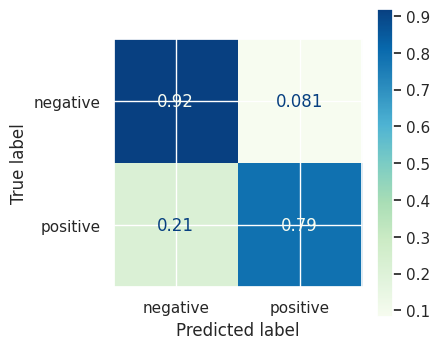

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1150
           1       0.82      0.90      0.86       850

    accuracy                           0.88      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



En este caso, como podemos ver, las métricas son levemente peores. Dado que estos modelos son capaces de captar estructuras más complejas, incluyendo puntuación, es posible que al preprocesar los textos estemos perdiendo algo de información.

Las primeras fases del entrenamiento parten de un punto peor, y el overfitting tarda algo más en aparecer. Podría ser indicativo de que el modelo tiene más adaptación, y estaría alineado con la hipótesis anterior.

Por resumir en una cifra, la `accuracy` de este modelo queda en 0.85.

In [ ]:
clear_memory()

## 1.3. Lemma

A continuación vamos a repetir el entrenamiento, pero esta vez aplicando lematización al los textos.

In [ ]:
model_name = 'distilbert-base-uncased'
processing = 'lemma_review'

### Dataset

In [ ]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training 

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/5
400/400 [==============================] - 208s 460ms/step - loss: 0.4172 - accuracy: 0.8094 - val_loss: 0.3425 - val_accuracy: 0.8456
Epoch 2/5
400/400 [==============================] - 180s 450ms/step - loss: 0.2342 - accuracy: 0.9131 - val_loss: 0.3301 - val_accuracy: 0.8637
Epoch 3/5
400/400 [==============================] - 188s 470ms/step - loss: 0.0997 - accuracy: 0.9675 - val_loss: 0.4354 - val_accuracy: 0.8612
Epoch 4/5
400/400 [==============================] - 180s 451ms/step - loss: 0.0596 - accuracy: 0.9816 - val_loss: 0.4435 - val_accuracy: 0.8662
Epoch 5/5
400/400 [==============================] - 180s 450ms/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.7559 - val_accuracy: 0.8294


In [ ]:
os.makedirs('models', exist_ok=True)
model.save_pretrained(f'models/{model_name}_{processing}', saved_model=True)

### Evaluation

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

125/125 [==============================] - 19s 142ms/step - loss: 0.7802 - accuracy: 0.8270


{'loss': 0.7802354097366333, 'accuracy': 0.8270000219345093}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{model_name}_{processing}.parquet')

125/125 [==============================] - 20s 142ms/step


<ipython-input-69-351d64bfe9ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
predictions = labels
labels = test_df['label']

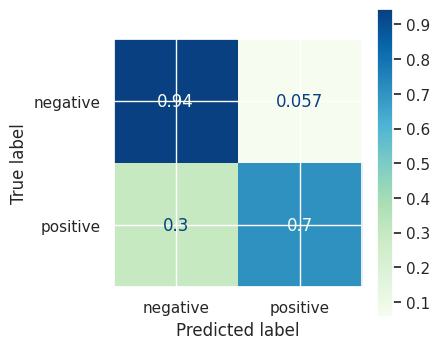

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1255
           1       0.75      0.94      0.84       745

    accuracy                           0.86      2000
   macro avg       0.85      0.88      0.86      2000
weighted avg       0.88      0.86      0.86      2000



En este caso los resultados son similares al caso anterior, pero con un overfitting más pronunciado. 

La métrica `accuracy` sobre el conjunto de test queda en un 0.83 aproximadamente.

In [ ]:
clear_memory()

## 1.4. Stem

Aunque en las pruebas anteriores hemos obtenido peores métricas cuanto más agresivo era el preprocesado, vamos a llevar a cabo una última prueba aplicando stemming a los textos.

Apoyándonos en lo que hemos visto, y que estos modelos no se han pre-entrenado utilizando estas técnicas, los resultados a priori no deberían ser mucho mejores que los anteriores.

In [ ]:
model_name = 'distilbert-base-uncased'
processing = 'stem_review'

### Dataset

In [ ]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/5
400/400 [==============================] - 249s 563ms/step - loss: 0.5061 - accuracy: 0.7473 - val_loss: 0.3635 - val_accuracy: 0.8450
Epoch 2/5
400/400 [==============================] - 224s 560ms/step - loss: 0.3013 - accuracy: 0.8803 - val_loss: 0.3540 - val_accuracy: 0.8612
Epoch 3/5
400/400 [==============================] - 219s 549ms/step - loss: 0.1729 - accuracy: 0.9402 - val_loss: 0.3905 - val_accuracy: 0.8462
Epoch 4/5
400/400 [==============================] - 219s 549ms/step - loss: 0.0866 - accuracy: 0.9714 - val_loss: 0.5048 - val_accuracy: 0.8506
Epoch 5/5
400/400 [==============================] - 224s 560ms/step - loss: 0.0442 - accuracy: 0.9858 - val_loss: 0.5099 - val_accuracy: 0.8525


In [ ]:
os.makedirs('models', exist_ok=True)
model.save_pretrained(f'models/{model_name}_{processing}', saved_model=True)

### Evaluation

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

125/125 [==============================] - 22s 166ms/step - loss: 0.5655 - accuracy: 0.8325


{'loss': 0.5654890537261963, 'accuracy': 0.8324999809265137}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{model_name}_{processing}.parquet')

125/125 [==============================] - 22s 163ms/step


<ipython-input-78-351d64bfe9ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
predictions = labels
labels = test_df['label']

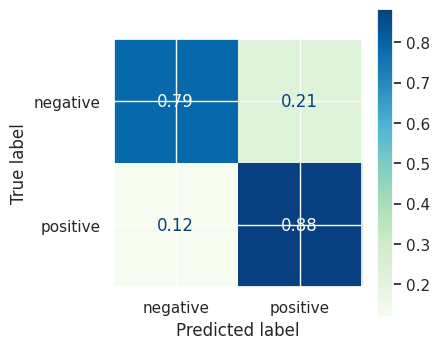

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       920
           1       0.90      0.78      0.84      1080

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000



Como esperábamos, los resultados no han mejorado mucho los dos casos anteriores, volviéndonos a quedar en una `accuracy` de 0.83.

Todas nuestras pruebas apuntan a que cuanto más se vea afectado el texto original, mayor será la pérdida de información de cara al modelo, y menor será su rendimiento.

Por ello, a partir de ahroa utilizaremos el texto bruto para realizar las siguientes pruebas.

In [ ]:
clear_memory()

# 2. Pretrained models

Una vez aclaradas las dudas sobre el preprocesado de los textos, vamos a trabajar con el texto en bruto (directamente con la columan `review` del dataset).

Vamos a volver a evaluar `distilbert` (aprovechamos a para comprobar la consistencia de los resultados), `distilroberta`, una variante del mismo, y `BERT`, el modelo original sin ninguna reducción.

## 2.1. Distilbert

Vamos a comenzar evaluando el modelo utilizado anteriormente, el cual es una versión optimizada en tamaño de BERT. Sobre el papel, es un 40% más pequeño, pero mantiene un 97% de su rendimiento.

In [ ]:
model_name = 'distilbert-base-uncased'
processing = 'review'

### Dataset

In [ ]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/5
400/400 [==============================] - 408s 953ms/step - loss: 0.3399 - accuracy: 0.8553 - val_loss: 0.2481 - val_accuracy: 0.8994
Epoch 2/5
400/400 [==============================] - 391s 979ms/step - loss: 0.1780 - accuracy: 0.9348 - val_loss: 0.2856 - val_accuracy: 0.8894
Epoch 3/5
400/400 [==============================] - 378s 945ms/step - loss: 0.0995 - accuracy: 0.9691 - val_loss: 0.2913 - val_accuracy: 0.8975
Epoch 4/5
400/400 [==============================] - 377s 943ms/step - loss: 0.0587 - accuracy: 0.9820 - val_loss: 0.3168 - val_accuracy: 0.8906
Epoch 5/5
400/400 [==============================] - 377s 944ms/step - loss: 0.0343 - accuracy: 0.9886 - val_loss: 0.4544 - val_accuracy: 0.8863


### Evaluation

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

125/125 [==============================] - 36s 274ms/step - loss: 0.4049 - accuracy: 0.8935


{'loss': 0.4048987329006195, 'accuracy': 0.8934999704360962}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

125/125 [==============================] - 35s 270ms/step


<ipython-input-36-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
predictions = labels
labels = test_df['label']

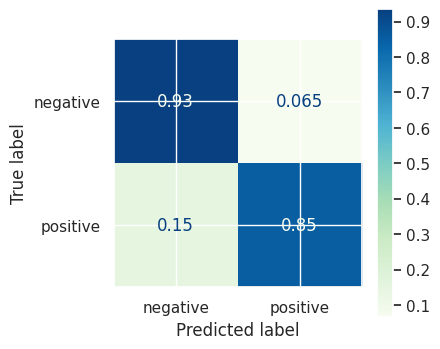

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1025
           1       0.93      0.85      0.89       975

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



Los resultados son muy similares a los obtenidos previamente, manteniéndonos en un 0.89 de `accuracy`, y tendencia al sobreajuste durante el entrenamiento (0.98 de accuracy sobre train).

Algo que no hemos mencionado es que es normal que la capacidad de generalización del modelo tras el reentrenamiento no sea extremadamente buena dado el tamaño de nuestro dataset.

En cuanto a tiempos, durante el entrenamiento cada step ha requerido entre 900ms y 1s, y durante la inferencia, entre 250ms y 300ms. Tomaremos estas cifras como referencia en las siguientes pruebas.

In [ ]:
clear_memory()

## 2.2. Distilroberta

A continuación vamos a repetir el proceso con `distilroberta`, un modelo muy similar al evaluado hasta el momento, pero con cambios en el proceso de enmascaramiento durante el entrenamiento.

Veamos si tiene un impacto notable en nuestras pruebas.

In [ ]:
model_name = 'distilroberta-base'
processing = 'review'

### Dataset

In [ ]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
400/400 [==============================] - 417s 956ms/step - loss: 0.3227 - accuracy: 0.8641 - val_loss: 0.2676 - val_accuracy: 0.8981
Epoch 2/5
400/400 [==============================] - 356s 891ms/step - loss: 0.1848 - accuracy: 0.9314 - val_loss: 0.3142 - val_accuracy: 0.8988
Epoch 3/5
400/400 [==============================] - 355s 888ms/step - loss: 0.1224 - accuracy: 0.9598 - val_loss: 0.3142 - val_accuracy: 0.9006
Epoch 4/5
400/400 [==============================] - 355s 888ms/step - loss: 0.0739 - accuracy: 0.9777 - val_loss: 0.3611 - val_accuracy: 0.8963
Epoch 5/5
400/400 [==============================] - 356s 890ms/step - loss: 0.0552 - accuracy: 0.9809 - val_loss: 0.4692 - val_accuracy: 0.8794


### Evaluation

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

125/125 [==============================] - 34s 257ms/step - loss: 0.4441 - accuracy: 0.8825


{'loss': 0.4441412091255188, 'accuracy': 0.8824999928474426}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

125/125 [==============================] - 33s 251ms/step


<ipython-input-51-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
predictions = labels
labels = test_df['label']

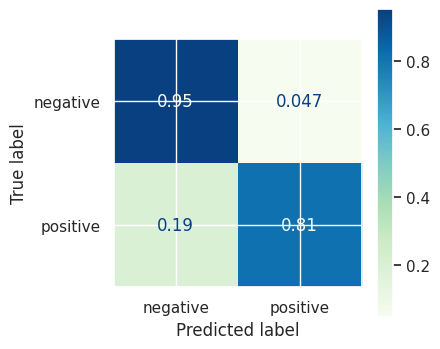

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1025
           1       0.94      0.81      0.87       975

    accuracy                           0.88      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.88      0.88      2000



Como podemos observar, no hay una gran diferencia entre ambos. El entrenamiento y la evaluación han dado resultados muy similares, con dos diferencias leves:

- la accuracy es algo inferior: 0.88
- los tiempos de respuesta son también algo inferiores, estando por debajo de los 900ms con frecuencia en entrenamiento, y entorno a los 250ms en inferencia.

La diferencia en tiempos, aunque leve, es interesante, dado que distilroberta tiene un numero mayor de parámetros que distilbert (82M vs 67M). Habría que hacer un análisis en profundidad para ver si esta diferencia viene provocada por los cambios en el enmascaramiento, u a otros factores.

In [ ]:
clear_memory()

## 2.3. BERT

Dado que nuestras pruebas con distilroberta no mejoraron las iniciales con distilbert, vamos a comparar ahora los resultados del modelo reducido contra el original. Recordemos que la diferencia en número de parámetros es bastante grande (67M vs 110M)

In [ ]:
model_name = 'bert-base-uncased'
processing = 'review'

### Dataset

In [ ]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
640/640 [==============================] - 711s 1s/step - loss: 0.3934 - accuracy: 0.8207 - val_loss: 0.3331 - val_accuracy: 0.8570
Epoch 2/5
640/640 [==============================] - 659s 1s/step - loss: 0.1910 - accuracy: 0.9301 - val_loss: 0.2620 - val_accuracy: 0.8961
Epoch 3/5
640/640 [==============================] - 659s 1s/step - loss: 0.1023 - accuracy: 0.9664 - val_loss: 0.3432 - val_accuracy: 0.8961
Epoch 4/5
640/640 [==============================] - 658s 1s/step - loss: 0.0750 - accuracy: 0.9752 - val_loss: 0.3690 - val_accuracy: 0.8906
Epoch 5/5
640/640 [==============================] - 658s 1s/step - loss: 0.0547 - accuracy: 0.9824 - val_loss: 0.4069 - val_accuracy: 0.8883


### Evaluation

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 64s 306ms/step - loss: 0.4012 - accuracy: 0.8832


{'loss': 0.40124717354774475, 'accuracy': 0.8831980228424072}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

201/201 [==============================] - 66s 307ms/step


<ipython-input-36-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
predictions = labels
labels = test_df['label']

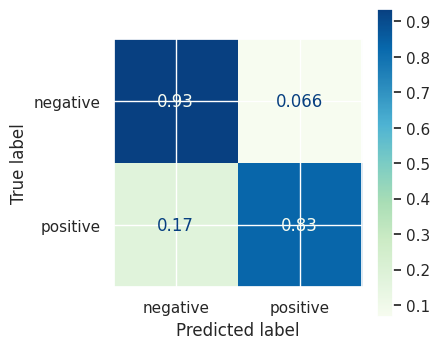

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       823
           1       0.92      0.83      0.87       778

    accuracy                           0.88      1601
   macro avg       0.89      0.88      0.88      1601
weighted avg       0.89      0.88      0.88      1601



Los resultados obtenidos son, de nuevo, muy similares a los mejores obtenidos (`accuracy`
 de 0.88). Sin embargo hemos encontrado dos diferencias principales:

 - El tamaño en memoria de GPU de BERT es prácticamente el doble que su verisón reducida, y esto ha provocado que debamos hacer algunos ajustes para que el entrenamiento se desarrollase sin problemas, como por ejemplo reducir el tamaño de los batches a 8 textos.
 - La reducción en el tamaño los batches hace que los tiempos por step no sean comparables, pero sí el tiempo global por epoch (aunque es cierto que es esperable cierto impacto). Sin embargo, vemos que los tiempos por epoch se han doblado.

 Por tanto, podemos concluir que la optimización de `distilbert` respecto al modelo original es efectiva, y al menos en nuestro caso, es preferible usar la version optimizada.

In [ ]:
clear_memory()

# 3. Specific models

Hemos reentrenado modelos de base generalista. En esta sección vamos a ver cómo cambia la situación partiendo de modelos que se han preentrenado para una tarea similar.

Para ello, hemos elegido modelos que se han reentrenado para tareas de sentiment analysis, y también para la categorización de comentarios de películas. Será interesante ver ómo sec adapótan unos y otros a la tarea.

## 3.1. Distilbert SST2

En primer lugar vamos a evaluar el rendimiento de distilbert, ajustado sobre el dataset [SST2](https://huggingface.co/datasets/sst2), que es un dataset etiquetado para sentiment analysis de 60K textos aproximadamente.

In [ ]:
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
processing = 'review'

### Dataset

In [ ]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/5
640/640 [==============================] - 345s 503ms/step - loss: 0.3157 - accuracy: 0.8707 - val_loss: 0.2569 - val_accuracy: 0.9070
Epoch 2/5
640/640 [==============================] - 323s 505ms/step - loss: 0.1722 - accuracy: 0.9389 - val_loss: 0.3291 - val_accuracy: 0.8875
Epoch 3/5
640/640 [==============================] - 342s 534ms/step - loss: 0.0901 - accuracy: 0.9691 - val_loss: 0.3711 - val_accuracy: 0.9039
Epoch 4/5
640/640 [==============================] - 324s 506ms/step - loss: 0.0425 - accuracy: 0.9846 - val_loss: 0.3884 - val_accuracy: 0.8914
Epoch 5/5
640/640 [==============================] - 323s 505ms/step - loss: 0.0502 - accuracy: 0.9822 - val_loss: 0.4452 - val_accuracy: 0.8961


### Evaluation

In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 32s 153ms/step - loss: 0.4107 - accuracy: 0.8869


{'loss': 0.4106643795967102, 'accuracy': 0.8869456648826599}

In [ ]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

201/201 [==============================] - 31s 145ms/step


<ipython-input-45-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [ ]:
predictions = labels
labels = test_df['label']

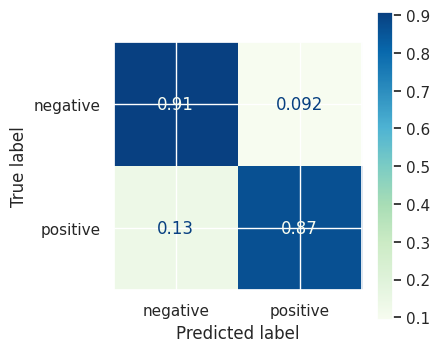

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       823
           1       0.90      0.87      0.88       778

    accuracy                           0.89      1601
   macro avg       0.89      0.89      0.89      1601
weighted avg       0.89      0.89      0.89      1601



Partiendo de este modelo afinado para una tarea similar (sentiment analysis), los resultados alcanzados han sido muy similares (accuracy de 0.88). 

La diferencia más notable ocurre durante el entrenamiento, donde se parte desde el inicio con mejores métricas (0.87 train_accuracy, 0.90 val_accuracy desde el primer epoch). Después, los problemas de sobreajuste aparecen y las métricas se igualan.

Por tanto, dado el sobreajuste que estamos obteniendo con estos modelos y para este problema, si se decide que el número de epochs deba reducirse, es donde podemos obtener una clara mejora de partir de este tipo de modelos. Por el momento, no se obtiene ninguna mejora clara con la configuración actual de nuestras pruebas.

In [ ]:
clear_memory()

## 3.2. Roberta sentiment tweet

Vamos a probar ahora con `roberta`, entrenado con un dataset de sentiment de twitter. Lo más significativo de este dataset es que los tweets tienen una limitación de longitud.

In [33]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
processing = 'review'

### Dataset

In [34]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Training

In [35]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
640/640 [==============================] - 714s 1s/step - loss: 0.3285 - accuracy: 0.8640 - val_loss: 0.3859 - val_accuracy: 0.8258
Epoch 2/5
640/640 [==============================] - 632s 988ms/step - loss: 0.2055 - accuracy: 0.9258 - val_loss: 0.3032 - val_accuracy: 0.8984
Epoch 3/5
640/640 [==============================] - 584s 913ms/step - loss: 0.1216 - accuracy: 0.9584 - val_loss: 0.3446 - val_accuracy: 0.9078
Epoch 4/5
640/640 [==============================] - 621s 971ms/step - loss: 0.1059 - accuracy: 0.9607 - val_loss: 0.3949 - val_accuracy: 0.9133
Epoch 5/5
640/640 [==============================] - 620s 969ms/step - loss: 0.0704 - accuracy: 0.9773 - val_loss: 0.4723 - val_accuracy: 0.8945


### Evaluation

In [36]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 57s 267ms/step - loss: 0.3730 - accuracy: 0.9082


{'loss': 0.3729613125324249, 'accuracy': 0.9081823825836182}

In [37]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

201/201 [==============================] - 58s 266ms/step


<ipython-input-37-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


In [38]:
predictions = labels
labels = test_df['label']

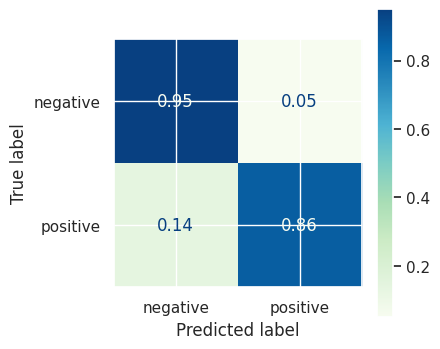

In [39]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [40]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       823
           1       0.94      0.86      0.90       778

    accuracy                           0.91      1601
   macro avg       0.91      0.91      0.91      1601
weighted avg       0.91      0.91      0.91      1601



En este caso hemos conseguido una leve mejoría, sobrepasando levemente la preciósni, pasando del 0.90 de accuracy. 

Respecto a los tiempos y tamaño, son similares a los BERT (teimpos levemente inferiores, como vimos en los modelos optimizados).

Las métricas durante el entrenamiento comienzan algo más bajas, pero mejoran antes de volver a caer en el sobreajuste. Podemos decir que reentrenando RoBERTa hemos obtenido el mejor resultado hasta el momento.

In [41]:
clear_memory()

## 3.3. Roberta SST2

Dados los resultados obtenidos con el modelo anterior, vamos a comprobar qué resultados obtenemos entrenando sobre el datset SST2, en lugar del dataset de sentiment-tweet, para entender si la mejora viene del modelo o del dataset.

In [44]:
model_name = 'Ibrahim-Alam/finetuning-roberta-base-on-sst2'
processing = 'review'

### Dataset

In [45]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

In [46]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Epoch 1/5
640/640 [==============================] - 680s 988ms/step - loss: 0.3026 - accuracy: 0.8830 - val_loss: 0.2648 - val_accuracy: 0.9172
Epoch 2/5
640/640 [==============================] - 600s 937ms/step - loss: 0.2391 - accuracy: 0.9181 - val_loss: 0.2601 - val_accuracy: 0.9172
Epoch 3/5
640/640 [==============================] - 598s 935ms/step - loss: 0.1718 - accuracy: 0.9420 - val_loss: 0.3867 - val_accuracy: 0.8672
Epoch 4/5
640/640 [==============================] - 599s 935ms/step - loss: 0.2761 - accuracy: 0.8883 - val_loss: 0.3780 - val_accuracy: 0.8687
Epoch 5/5
640/640 [==============================] - 598s 935ms/step - loss: 0.1299 - accuracy: 0.9574 - val_loss: 0.2876 - val_accuracy: 0.9031


### Evaluation

In [47]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 57s 269ms/step - loss: 0.2983 - accuracy: 0.9038


{'loss': 0.2983092963695526, 'accuracy': 0.9038101434707642}

In [48]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

201/201 [==============================] - 56s 266ms/step


<ipython-input-48-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


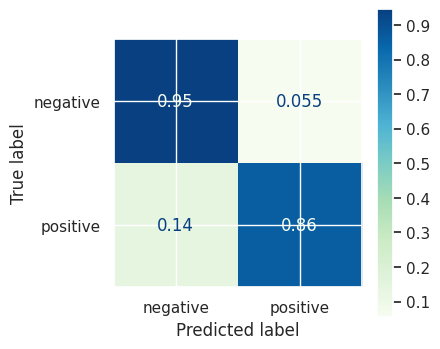

In [49]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [50]:
predictions = labels
labels = test_df['label']

In [51]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       823
           1       0.94      0.86      0.90       778

    accuracy                           0.90      1601
   macro avg       0.91      0.90      0.90      1601
weighted avg       0.91      0.90      0.90      1601



Los resultados obtenidos, como podemos observar, son muy similares a los del punto anterior, por lo que podemos concluir que la mejora obtenida se debe principalemete al modelo.

Sin embargo, durante el entrenamiento las métricas sobre el conjunto de validación se han ido reduciendo desde el inicio, por lo que cabe sospechar que en cierta manera, cuando el modelo está finado para esta tarea, es posible que estemos empeorando la adecuación del modelo. Por ello, vamos a buscar en los siguientes puntos modelos afinados para la misma tarea, y medir los resultados antes y después del entrenamiento.

In [52]:
clear_memory()

## 3.4. Distilbert imdb

Para los siguientes apartados, vamos a elegir modelos afinados para la clasificaocin de reviews de películas sobre los comentarios de imdb.

Comenzaremos por idstilbert, que ha sido el baseline desde el principio de la práctica.

In [52]:
model_name = 'lvwerra/distilbert-imdb'
processing = 'review'

### Dataset

In [53]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

Antes de entrenar vamos a medir la precisión del modelo sin llevar a cabo ningún reentrenamiento sobre nuestro dataset. Dado que la tarea es prácticamente la misma, y en algunas pruebas previas hemos visto que el entrenamiento parte desde una accuracy alta, vamos a llevar a cabo esta prueba y a entrenar posteriormente.

In [54]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [55]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 34s 148ms/step - loss: 0.1123 - accuracy: 0.9594


{'loss': 0.11227598041296005, 'accuracy': 0.9594003558158875}

Como podemos observar, la métrica `accuracy` que tiene el modelo es bastante más alta que la obtenida hasta el momento: 0.95. A continuacóin vamos a reentrenar el modelo sobre nuestros datos.

In [56]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/5
640/640 [==============================] - 341s 493ms/step - loss: 0.2199 - accuracy: 0.9137 - val_loss: 0.2008 - val_accuracy: 0.9297
Epoch 2/5
640/640 [==============================] - 309s 483ms/step - loss: 0.1001 - accuracy: 0.9652 - val_loss: 0.2833 - val_accuracy: 0.9094
Epoch 3/5
640/640 [==============================] - 309s 483ms/step - loss: 0.0682 - accuracy: 0.9781 - val_loss: 0.5556 - val_accuracy: 0.8500
Epoch 4/5
640/640 [==============================] - 328s 513ms/step - loss: 0.0543 - accuracy: 0.9803 - val_loss: 0.2995 - val_accuracy: 0.9062
Epoch 5/5
640/640 [==============================] - 333s 520ms/step - loss: 0.0392 - accuracy: 0.9861 - val_loss: 0.3230 - val_accuracy: 0.9172


Podemos ver claramente como la métricaé de referencia sobre la partición de train sigue creciendo, al igual que la evaluación de la función de pérdida sobre el conjunto de entrenamiento. Sin embargo, sobre el conjunto de validación las métricas no paran de empeorar desde el inicio. 

Claramente esto indica que estamos degradando la capacidad de generalización del modelo. Esta tendencia al sobre ajuste probablemente se deba al gran tamaño del modelo en comparación con el dataset de entrenamiento. 

### Evaluation

In [57]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 33s 150ms/step - loss: 0.3069 - accuracy: 0.9088


{'loss': 0.30693620443344116, 'accuracy': 0.9088069796562195}

In [58]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

201/201 [==============================] - 31s 145ms/step


<ipython-input-58-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


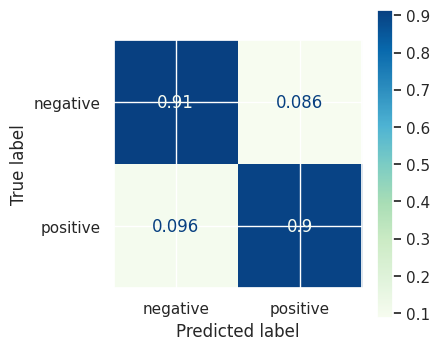

In [59]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [60]:
predictions = labels
labels = test_df['label']

In [61]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       823
           1       0.91      0.90      0.91       778

    accuracy                           0.91      1601
   macro avg       0.91      0.91      0.91      1601
weighted avg       0.91      0.91      0.91      1601



Aunque las métricas finales obtenidas están en la linea de lasobtenidas tras entrenar otros modelos, son resultado de una degradación del modelo de partida. 

Por tanto, en este caso, el reentrenamiento del modelo para una tarea similar provoca únicamente un fuerte sobreajuste.

In [62]:
clear_memory()

## 3.5. Roberta imdb

Por último, vamos a probar con un modelo más grande, entrenado para la misma tarea, y observar el resultado. En este punto la hipótesis es que debería funcionar mejor el modelo antes de hacer nosotros un ajuste específico.

In [63]:
model_name = 'aychang/roberta-base-imdb'
processing = 'review'

### Dataset

In [64]:
dataset['text'] = dataset[processing]
train_df = dataset[dataset['partition'] == 'train']
train_df, val_df = train_test_split(train_df, shuffle=False, test_size=0.2)
test_df = dataset[dataset['partition'] == 'test']

tokenizador = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizador(list(train_df["text"].values),
                            truncation=True, 
                            padding=True)
val_encodings = tokenizador(list(val_df["text"].values),
                            truncation=True, 
                            padding=True)
test_encodings = tokenizador(list(test_df["text"].values),
                            truncation=True, 
                            padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_df["label"].values)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_df["label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(test_df["label"].values)))

### Training

Al igual que en el apartado anterior, vamos a llevar a cabo una evaluación del modelo original.

In [65]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [66]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 62s 269ms/step - loss: 0.0996 - accuracy: 0.9775


{'loss': 0.09956362843513489, 'accuracy': 0.9775140285491943}

En este caso obtenemos las mejores métricas obtenidas hasta el momento, con una `accuracy` de 0.97. 

Vamos a re-entrenar el modelo para observar los resultados.

In [67]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset.batch(BATCH_SIZE),
#    callbacks=[checkpoint_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Epoch 1/5
640/640 [==============================] - 693s 957ms/step - loss: 0.2136 - accuracy: 0.9269 - val_loss: 0.1865 - val_accuracy: 0.9422
Epoch 2/5
640/640 [==============================] - 583s 911ms/step - loss: 0.1806 - accuracy: 0.9357 - val_loss: 0.1844 - val_accuracy: 0.9406
Epoch 3/5
640/640 [==============================] - 617s 964ms/step - loss: 0.1482 - accuracy: 0.9496 - val_loss: 0.1631 - val_accuracy: 0.9477
Epoch 4/5
640/640 [==============================] - 574s 896ms/step - loss: 0.1441 - accuracy: 0.9553 - val_loss: 0.3090 - val_accuracy: 0.9047
Epoch 5/5
640/640 [==============================] - 573s 896ms/step - loss: 0.4313 - accuracy: 0.7541 - val_loss: 0.6964 - val_accuracy: 0.4992


Efectivamente, tras este entrenamiento parece que nuestra hipótesis se confirma y este ajuste simplemente ha servido para que el modelo se ajuste demasiado al dataset de entrenamiento, perdiendo capacidad de generalización. Vamos a evaluar contra el conjunto de test para confirmarlo.

### Evaluation

In [68]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 56s 264ms/step - loss: 0.6988 - accuracy: 0.4859


{'loss': 0.6988314390182495, 'accuracy': 0.48594629764556885}

Confirmamos la pérdida de calidad del modelo de cara a la tarea planteada. Por tanto, para finalizar, vamos a evaluar el modelo original.

In [74]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, from_pt=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [75]:
model.evaluate(test_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

201/201 [==============================] - 59s 262ms/step - loss: 0.0996 - accuracy: 0.9775


{'loss': 0.09956362843513489, 'accuracy': 0.9775140285491943}

In [76]:
predicciones = model.predict(test_dataset.batch(BATCH_SIZE))
#obtenemos las probabilidades
res = tf.nn.softmax(predicciones.logits, axis=1).numpy()
labels = np.argmax(res, axis=1)
colname = model_name.replace('-', '_') + '_pred'
local_model_name = model_name.replace('/', '_')
test_df[colname] = labels
os.makedirs('results', exist_ok=True)
test_df.to_parquet(f'results/{local_model_name}_{processing}.parquet')

201/201 [==============================] - 55s 260ms/step


<ipython-input-76-dd144c4934bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[colname] = labels


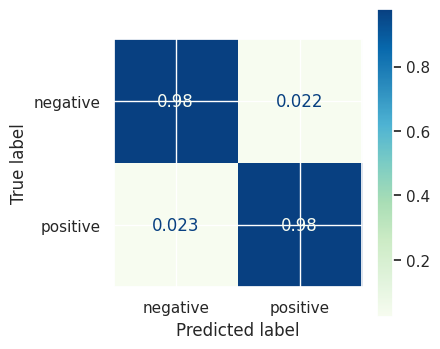

In [77]:
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['label'],
    test_df[colname],
    normalize='true',
    display_labels=['negative', 'positive'],
    cmap='GnBu'
)

In [78]:
predictions = labels
labels = test_df['label']

In [79]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       823
           1       0.98      0.98      0.98       778

    accuracy                           0.98      1601
   macro avg       0.98      0.98      0.98      1601
weighted avg       0.98      0.98      0.98      1601



Observamos como las métricas obtenidas son, con diferencia, las mejores obtenidas hasta el momento, con todas las principales métricas entre el 0.97 t 0.98.

Además destacar que el modelo está bastante equilibrado, sin ningún sesgo aparente hacia una u otra categoría.

In [80]:
clear_memory()

# Conclusión

Como hemos podido observar, este tipo de modelos tiene un gran potencial, pero dado su tamaño, es fácil que caer en el sobreajuste. Para modelos generalistas, podemos obtener mediante reentrenamiento una leve especialización, pero si queremos exprimirlos al máximo y obtener unos resultados óptimos, es necesaria una gran cantidad de informacioón, y dedicar tiempo a afinar los ajustes en el reentrenamiento.